In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import math

In [2]:
path_to_test_folder = "evaluation/fake_test/Task2/"
path_to_auxiliary_folder = 'auxiliary_images/'
results_path = "evaluation/submission_files/Birta_Nandor_407/Task2"

For this second task, the approach comprised of the following steps: <br>
Define manualy the pie slices based on the template for the purpose of scoring. Extract the double and triple regions (rings) from the template by checking the contours; smooth these contours by fitting an ellipse for each of them. <br>
Filter the images such that the only remaining part is the metal handle of the dart. Then, apply contour detection around this hypotethic metal part and fit a minimum area rectangle around a given contour. Next, based on the rotation angle take the left side of the rectangle and extend its middle point leftwards. Lastly check which ring and pie slice the aforementioned point belongs to.



In [3]:
def read_images(path):
    image_paths = [fpath for fpath in sorted(os.listdir(path)) if fpath[-3:] == 'jpg']
    
    images = []
    for img_path in image_paths:
        img_name = img_path.split('.')[0]
        img = cv2.imread(path + img_path)
        images.append((img_name, img))
    return images

In [4]:
# Save results (darts configuration)
def save_config(img_name, img_config, destination_path):
    with open(f"{destination_path}/{img_name}_predicted.txt", 'w') as f:
        f.writelines(str(len(img_config)) + '\n')
        if len(img_config):
            f.writelines('\n'.join([str(i) for i in sorted(img_config)]))

In [5]:
# Manually defined pie slices, based on the template image;
# A slice will be defined by two (left and right) points and the center of the board
slices = {key:{"left":None, 'right': None} for key in range(1,20) }
slices[20] = {'left': (1133, 783), 'right': (1397, 807)}
slices[1] = {'left': (1397, 807), 'right': (1628, 930)}
slices[18] = {'left': (1628, 930), 'right': (1810, 1121)}
slices[4] = {'left': (1810, 1121), 'right': (1942, 1367)}
slices[13] = {'left': (1942, 1367), 'right': (2005, 1626)}
slices[6] = {'left': (2005, 1626), 'right': (2017, 1900)}
slices[10] = {'left': (2017, 1900), 'right': (1977, 2174)}
slices[15] = {'left': (1977, 2174), 'right': (1880, 2429)}
slices[2] = {'left': (1880, 2429), 'right': (1731, 2660)}
slices[17] = {'left': (1731, 2660), 'right': (1508, 2846)}
slices[3] = {'left':  (1508, 2846), 'right': (1262, 2940)}
slices[19] = {'left': (1262, 2940), 'right': (982, 2932)}
slices[7] = {'left': (982, 2932), 'right': (710, 2786)}
slices[16] = {'left':  (710, 2786), 'right': (475, 2510)}
slices[8] = {'left': (475, 2510), 'right': (350, 2183)}
slices[11] = {'left':  (350, 2183), 'right': (315, 1782)}
slices[14] = {'left': (315, 1782), 'right': (420, 1406)}
slices[9] = {'left': (420, 1406), 'right': (600, 1085)}
slices[12] = {'left': (600, 1085), 'right': (860, 870)}
slices[5] = {'left': (860, 870), 'right': (1133, 783)}

In [6]:
test_images = read_images(path_to_test_folder)
aux_images = read_images(path_to_auxiliary_folder)

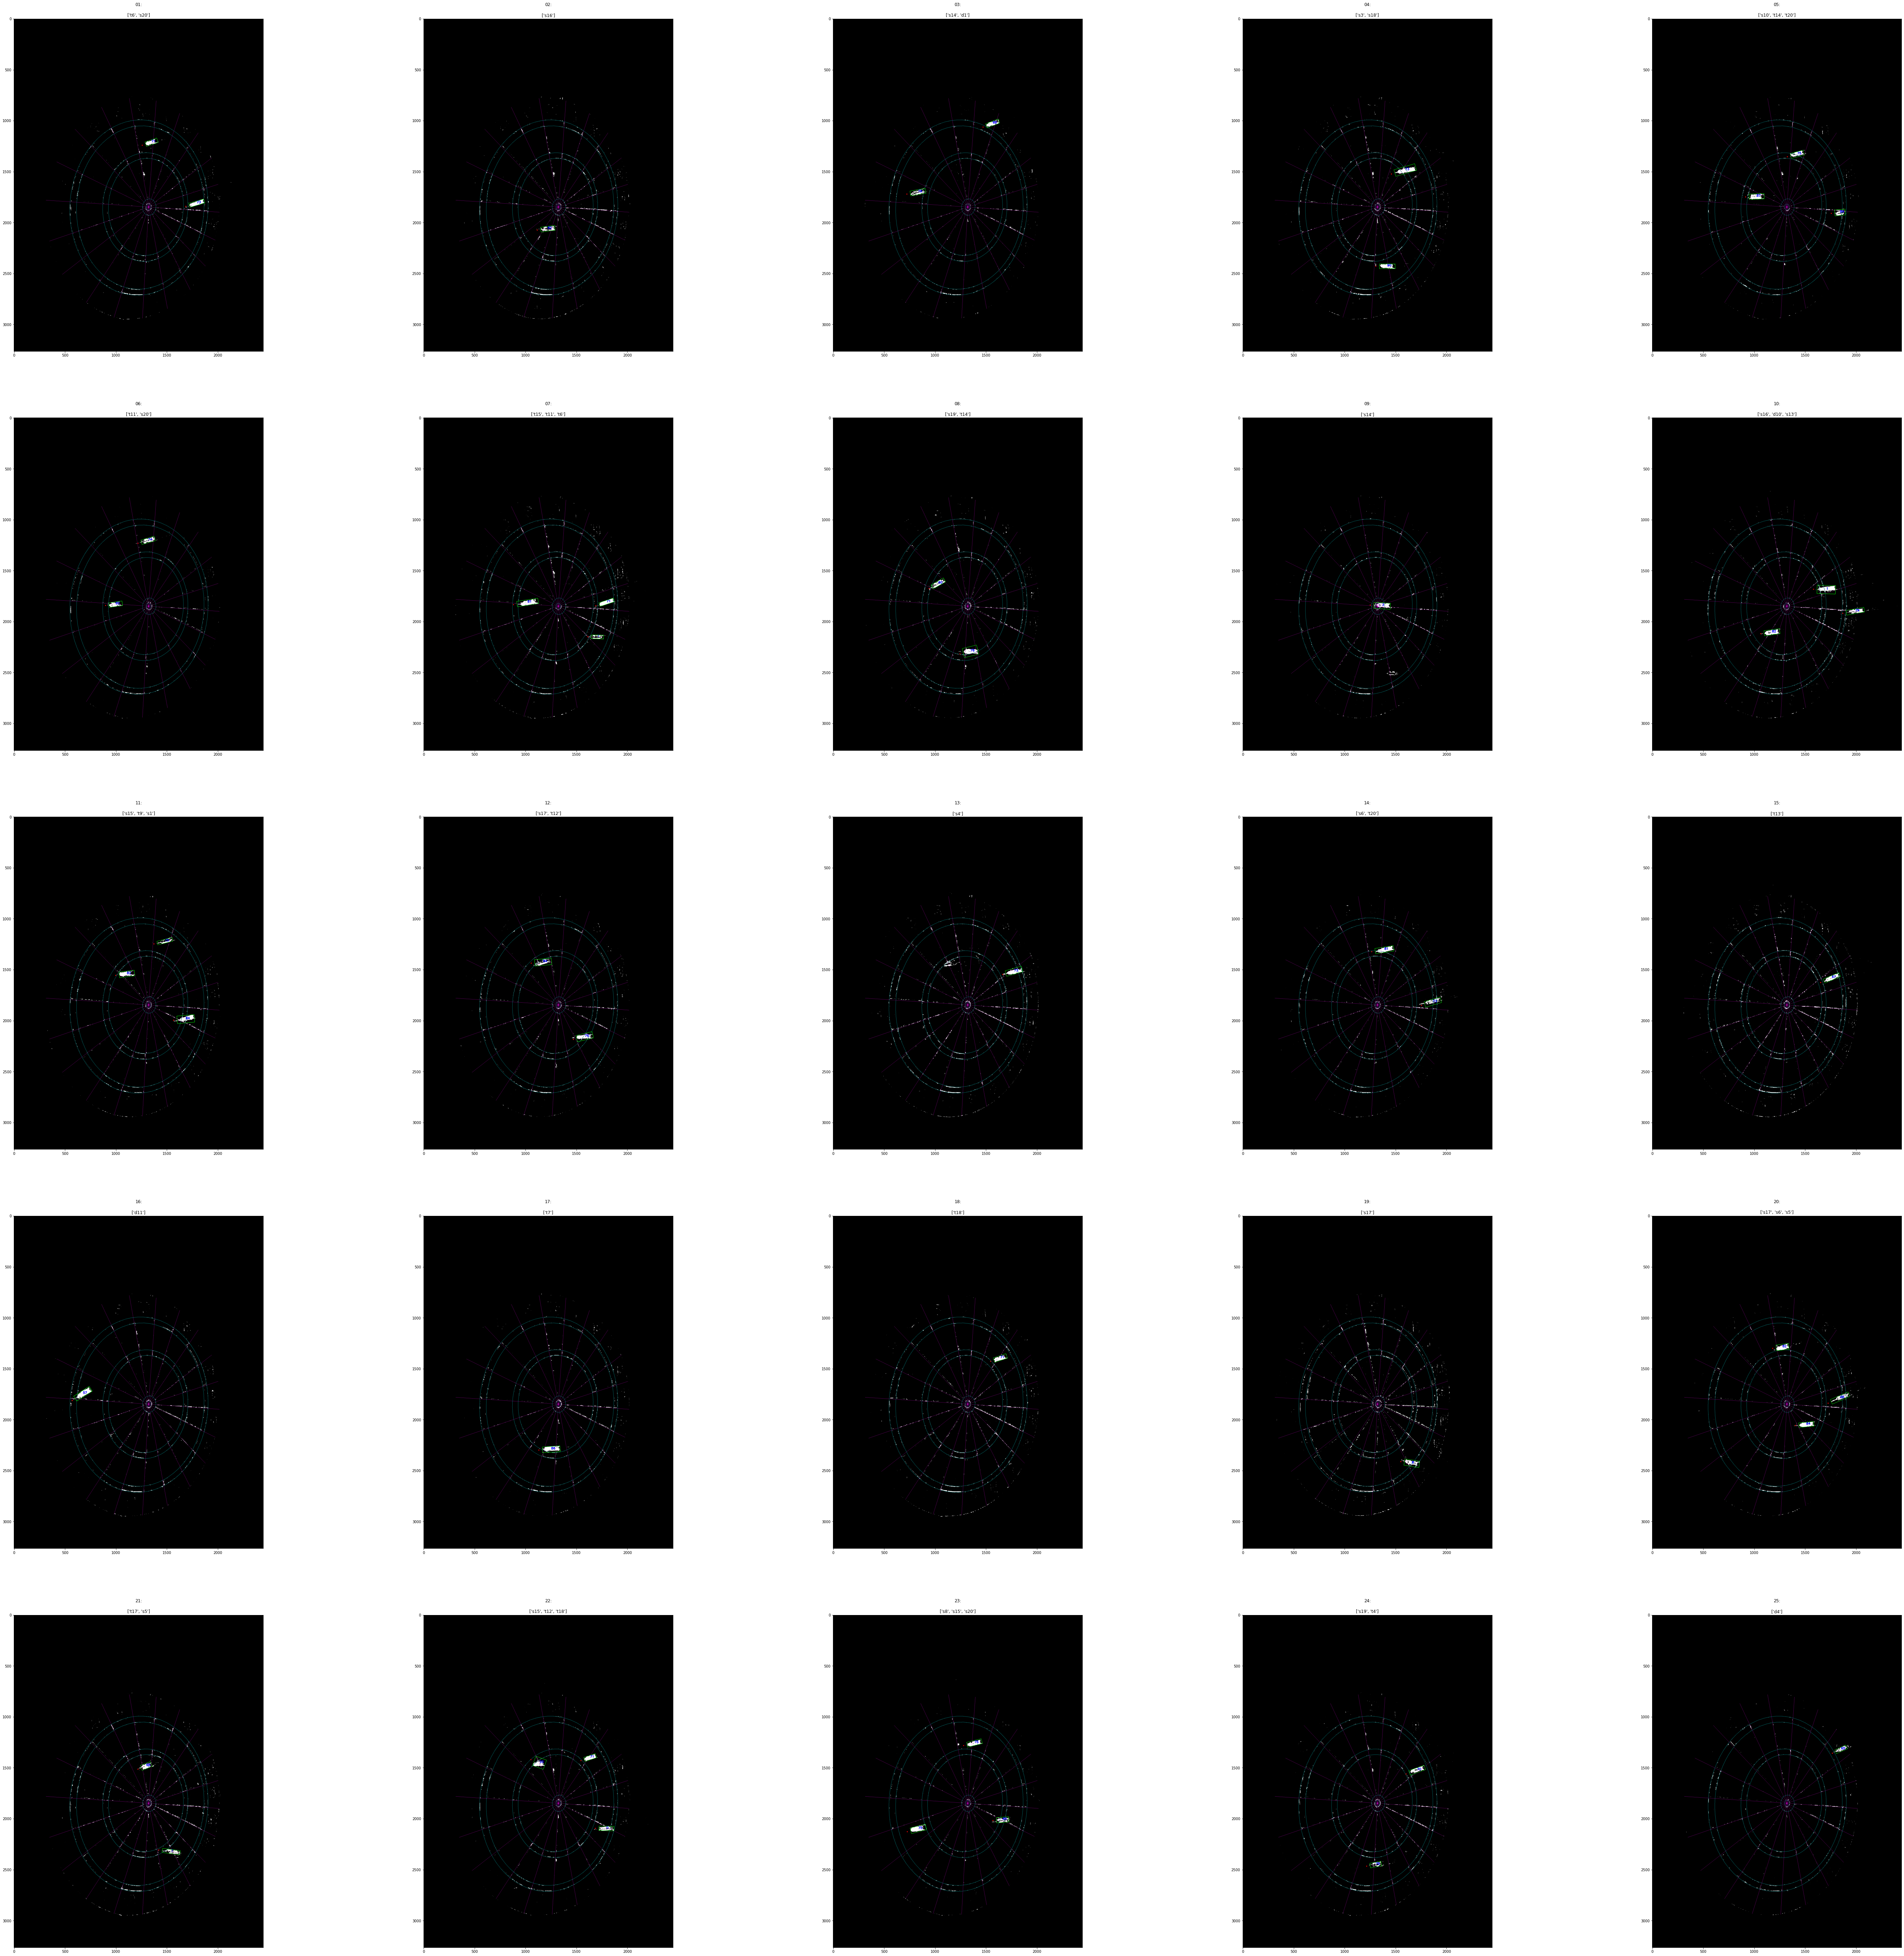

In [7]:
# Figure 
fig, axs = plt.subplots(nrows=5, ncols=5, figsize = (100,100))

# Filtering for the rings that are made up of red and green regions
lower_green_red = (0, 60, 40)
upper_green_red = (180,255,255)

# Separate filter for the bullseye
lower_bull_red = (0,100,100)
upper_bull_red = (180,255,255)


template_ = copy.deepcopy(aux_images[4][1])

# Convert template to hsv
hsv_img = cv2.cvtColor(template_, cv2.COLOR_BGR2HSV)

# Apply the color filter and get rid of thinner elements in the picture by erosion
mask = cv2.inRange(hsv_img, lower_green_red, upper_green_red)
mask = cv2.erode(mask, (5,5), iterations=5)
# Applying blur before contour detection
mask = cv2.GaussianBlur(mask, (15, 15), cv2.BORDER_CONSTANT)


# Given a minimum area, collect all contours
min_area = 50 * 50
contours_rings, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours_rings = [cnt for cnt in contours_rings if cv2.contourArea(cnt) > min_area]

# Separate masking for the bullseye, and similarly retrieving the contour
mask_bull = cv2.inRange(hsv_img, lower_bull_red, upper_bull_red)
contours_bull_red, _ = cv2.findContours(mask_bull, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours_bull_red = [cnt for cnt in contours_bull_red if (cv2.contourArea(cnt) < min_area) and (cv2.contourArea(cnt) > 25*25)]

# To get a somewhat smoother delimitation of regions, fit an ellipse to the larger contours and the special case
bull50_ellipse = cv2.fitEllipse(contours_bull_red[0])

ellipsis_ = []
ellipsis_.append(bull50_ellipse)
for cnt in contours_rings:
    ellipse = cv2.fitEllipse(cnt)
    ellipsis_.append(ellipse) 


# Reverse the list of ellipses, as to have it in descending order
ellipsis_ = list(reversed(ellipsis_))

# Draw rings on canvas, from which a second round of contours are retrieved, used later to determine the position of the darts
rings_empty = np.zeros_like(mask)
for el in ellipsis_:
    cv2.ellipse(rings_empty, el, 255, 1)


ellipsis_contours, _ = cv2.findContours(rings_empty, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
ellipsis_contours = [cnt for cnt in ellipsis_contours]

# For some reason this second step broke at some point and every ellipse contour ended up twice in the array
# As a last resort I subsampled the original array, taking every second contour
ellipsis_contours = ellipsis_contours[0::2]

# Save the center of the board in two variables
board_center_x = int(ellipsis_[-1][0][0])
board_center_y = int(ellipsis_[-1][0][1])

# The upper and lower boudaries for three subsequent levels of hsv-filtering 
lower = (0, 25, 25)
upper = (180,255,255)

lower_1 = (5,15,10)
upper_1 = (60, 255,255)

lower_2 = (1,30,1)
upper_2 = (180,255,255)

# Kernel size for the erosion
kernel = np.ones((3, 3), np.uint8)

i = 0
for img_name, img in copy.deepcopy(test_images):
    ax = plt.subplot(5, 5, i + 1)
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # With the first mask, large black and white regions are removed
    mask1 = cv2.inRange(hsv_img, lower, upper)
    res = cv2.bitwise_and(img, img, mask=mask1)

    # The second mask is used to remove the green, red and blue parts of the image 

    hsv_img = cv2.cvtColor(res, cv2.COLOR_BGR2HSV)
    mask2 = cv2.inRange(hsv_img, lower_1, upper_1)
    res = cv2.bitwise_and(img, img, mask=mask2)

    # The third mask is used to remove other smaller/thinner elements of the image
    hsv_img = cv2.cvtColor(res, cv2.COLOR_BGR2HSV)
    mask3 = cv2.inRange(hsv_img, lower_2, upper_2)

    # The resulting mask mostly contains the metal part of the darts
    mask = mask3

    # As there are still many noisy elements in the image, apply erosion to get rid of most 
    mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel, iterations=1)
    
    # Given a min area, try to identify these metal part of the darts
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    filtered_cnt = []
    min_area_dart = 40 * 40

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area_dart:
            filtered_cnt.append(cnt)


    # Create an RGB version of the mask, just for visulaization purposes
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)


    # Draw ellipses and pie slices onto the color mask
    for el in ellipsis_:
        cv2.ellipse(mask_color, el,(0,100,100), 2)
    
    for idx, endpoint in slices.items():
        cv2.line(mask_color, (board_center_x, board_center_y), endpoint['left'], color = (255, 0, 255), thickness = 1)


    # Dart identification and scoring
    preds = []
    for cnt in filtered_cnt:
        # For each identified contour calculate a minimum enclosing rectangle, then using the angle extend it towards left
        ((center_x, center_y), (height, width), rotation) = cv2.minAreaRect(cnt)
        min_rect = np.int0(cv2.boxPoints(((center_x, center_y), (height, width), rotation)))
        
        # Cases for two orientations 
        if rotation > 45:
            rotation_radian = (rotation - 90)*(np.pi/180)
        else:
            rotation_radian = rotation*(np.pi/180)
            width, height = height, width

        # The length of the extension: how much further left should the hipotetical tip be 
        extension = 35
        
        # The length of the extension calcuated from the center of the rectangle
        r = width / 2 + extension

        x_extended =  int(center_x) - int(r * math.cos(rotation_radian)) 
        y_extended =  int(center_y) - int(r * math.sin(rotation_radian)) 
        
        # Just for visualization purposes; the location of the tip and the angle of the rectangle
        cv2.putText(mask_color, f"{int(rotation)}", (int(center_x), int(center_y)),fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,255), thickness = 3)
        cv2.circle(mask_color, (x_extended, y_extended), 5, color = (255,0,0), thickness=-1)        
        
        # For scoring define subsequent levels, for the first four assign its corresponding pie slice value
        levels = ['d', 's', 't', 's', 'b25', 'b50']
        current_score_idx = -1

        # Given the earlier identified ellipsis contours, whether the extended point is in the ellipse;
        # Similarly, check if the same point is within the boundaries of any pie 
        for level_score, level_contour in zip(levels, ellipsis_contours):
            if cv2.pointPolygonTest(level_contour, (x_extended, y_extended), True) >= 1:
                current_score_idx += 1
        
        # current score idx is not in 

        if current_score_idx > -1:
            for slice_id, slice_borders in slices.items():
                slice_triangle = [slice_borders['left'], slice_borders['right'], (board_center_x, board_center_y)]
                if cv2.pointPolygonTest(np.array(slice_triangle), (x_extended, y_extended), True) >= 0:
                    slice_idx = slice_id
            if current_score_idx < 4:
                # if not the bull values, add pie score to the level string
                preds.append(levels[current_score_idx] + str(slice_idx))
            else:
                preds.append(levels[current_score_idx])
        
        # Draw minimum enclosing rectangles onto the color mask, just for visulaization purposes
        cv2.drawContours(mask_color, [min_rect], 0, (0, 255, 0), 2) 

    
    # Save darts configuration
    save_config(img_name, preds, results_path)

    # Plot the color masks
    plt.imshow(mask_color)
    plt.title(f"{img_name}:\n" + f"\n{preds}")

    i += 1